In [1]:
###########################
#classical shor algorithm for the factorization
#of a number in prime factors
###########################

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex

In [19]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

In [4]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return 
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 
    

In [5]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) #possibly dimezzare op. number
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [6]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [7]:
y = 2
N = 15
check(N)

Divisor: a = 3


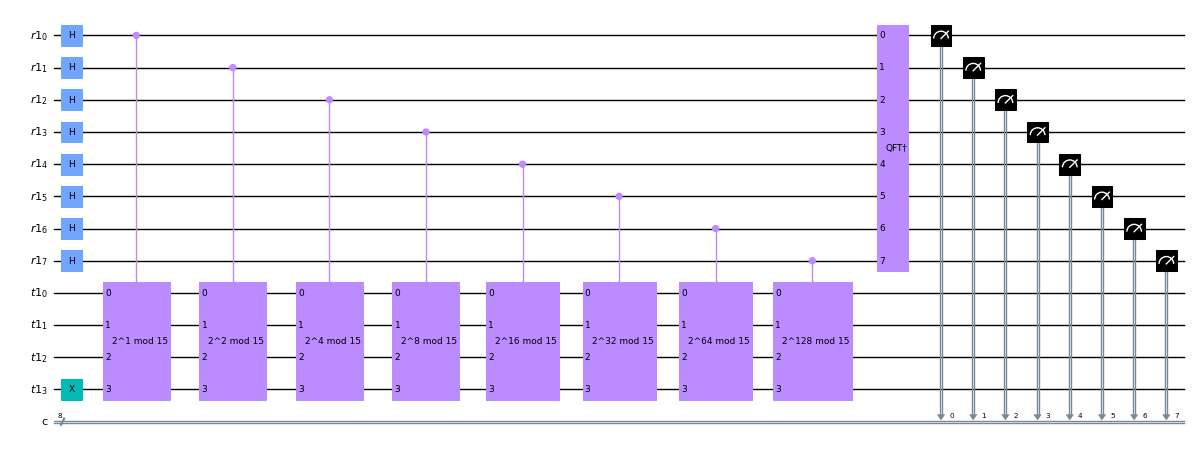

In [8]:
n = math.ceil(math.log(N,2))
control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')

circuit = QuantumCircuit(control, target, classic)

circuit.h(range(2*n))
circuit.x(2*n + n -1)
    
for q in range(2*n):
    circuit.append(mod_exp(n, y, N, q),     
             [q] + [i+2*n for i in range(n)])    
        
circuit.append(qft_dagger(2*n), range(2*n))   
circuit.measure(range(2*n), range(2*n))

circuit.draw(fold = -1, output='mpl', scale = 0.5)      

In [20]:
  
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc)                             #1024 shots
results = aer_sim.run(qobj).result()

counts = results.get_counts()

labels = []
for i in range(len(counts)):
    labels.append(   int(list(counts.keys())[i], 2 )   )
    
new_counts = dict(zip(labels,list(counts.values()) ))

plot_histogram(new_counts)

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr12.tfm' in your texmf tree, but could not find it

<Figure size 700x500 with 1 Axes>

In [11]:
import pandas as pd

n_count = 2*n
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2)                       # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)                   # Find corresponding eigenvalue
    measured_phases.append(phase)
                                                   # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
                                                   # Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)


            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [12]:
from fractions import Fraction

rows = []
period = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
    period.append(frac.denominator)

headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.25      1/4            4
2   0.75      3/4            4
3   0.00      0/1            1


In [13]:

r = max(period)

guesses = [gcd(y**(r//2)-1, N), gcd(y**(r//2)+1, N)]
print(guesses)

[3, 5]


In [14]:
df

,Phase,Fraction,Guess for r
0,0.50,1/2,2
1,0.25,1/4,4
2,0.75,3/4,4
3,0.00,0/1,1
